# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### 1.1 Загрузка датасетов

In [ ]:
# Блок загрузки библиотек
import pandas as pd                # библиотека для анализа и обработки данных в Python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

# Для векторизации текстов
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatize = WordNetLemmatizer()

# Для векторизации изрбражений
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from pathlib import Path

# Для подготовки обучающей и тестовой выборки
from sklearn.model_selection import GroupShuffleSplit

# Для масштабирования данных
from sklearn.preprocessing import StandardScaler

# Для построении нейронной сети
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Для модели линейной регрессии
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Для ускорения процесса обучения модели подключим GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Ранее использовал для подгрузки данных с моего google диска
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Загрузка датасета
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -qo dsplus_integrated_project_4.zip

DATA_PATH = '/content/to_upload'

In [ ]:
# Читаем данные
train_dataset = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))
CrowdAnnotations = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t',
                               names=['image', 'query_id', 'dol', 'col_poz', 'col_neg'])
ExpertAnnotations = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'first', 'second', 'third'])
test_queries = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), sep='|', index_col=0)
test_images = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'), sep='|')

### 1.2 Изучение информации о датасетах

In [ ]:
# Функция для изучения информации о датасете
def data_info(data):

    # Вывод первых 5 строк таблицы
    print(f'Первые 5 строк таблицы:')
    display(data.head(5))
    print('')

    # Вывод информации о таблице
    print(f'Информация о таблице:')
    display(data.info())
    print('')

    # Проверка на пропуски в данных
    missing_values = data.isnull().sum()
    percent_missing = data.isnull().sum() * 100 / len(data)
    missing_data = pd.DataFrame({'Кол-во пропусков': missing_values, '% пропусков': percent_missing})
    print(f'Таблица пропусков в данных таблицы: ')
    display(missing_data)
    print('')

    # Проверка на дубликаты
    print(f'\nКоличество дубликатов в таблице:  {data.duplicated().sum()}')

In [ ]:
# Датасет с информацией необходимой для обучения
data_info(train_dataset)

Первые 5 строк таблицы:


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None


Таблица пропусков в данных таблицы: 


Кол-во пропусков  % пропусков
image                      0          0.0
query_id                   0          0.0
query_text                 0          0.0



Количество дубликатов в таблице:  0


In [ ]:
# Датасет с данными по соответствию изображения и описания, полученные с помощью краудсорсинга
data_info(CrowdAnnotations)

Первые 5 строк таблицы:


image                     query_id  dol  col_poz  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0        3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0        0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0        0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0        0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0        0   

   col_neg  
0        0  
1        3  
2        3  
3        3  
4        3


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   dol       47830 non-null  float64
 3   col_poz   47830 non-null  int64  
 4   col_neg   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None


Таблица пропусков в данных таблицы: 


Кол-во пропусков  % пропусков
image                    0          0.0
query_id                 0          0.0
dol                      0          0.0
col_poz                  0          0.0
col_neg                  0          0.0



Количество дубликатов в таблице:  0


In [ ]:
# Датасет с данными по соответствию изображения и описания, полученные в результате опроса экспертов
data_info(ExpertAnnotations)

Первые 5 строк таблицы:


image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None


Таблица пропусков в данных таблицы: 


Кол-во пропусков  % пропусков
image                    0          0.0
query_id                 0          0.0
first                    0          0.0
second                   0          0.0
third                    0          0.0



Количество дубликатов в таблице:  0


In [ ]:
# Датасет с данными необходимыми для тестирования
data_info(test_queries)

Первые 5 строк таблицы:


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None


Таблица пропусков в данных таблицы: 


Кол-во пропусков  % пропусков
query_id                   0          0.0
query_text                 0          0.0
image                      0          0.0



Количество дубликатов в таблице:  0


In [ ]:
# Датасет с названиями изображений для тестирования модели
data_info(test_images)

Первые 5 строк таблицы:


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None


Таблица пропусков в данных таблицы: 


Кол-во пропусков  % пропусков
image                 0          0.0



Количество дубликатов в таблице:  0


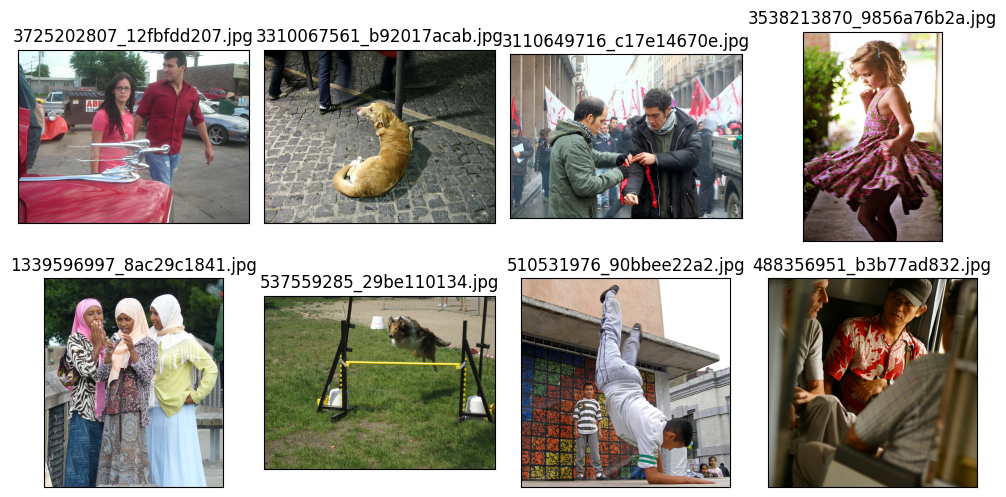

In [ ]:
# Посмотрим фотографии в датасете с информацией необходимой для обучения
foto_train = list(train_dataset['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    #image_path = os.path.join('/content/drive/My Drive/Colab Notebooks/to_upload/train_images', foto_train[i])
    image_path = os.path.join(DATA_PATH, 'train_images', foto_train[i])
    image1 = Image.open(image_path)
    plt.imshow(image1)
    plt.title(foto_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

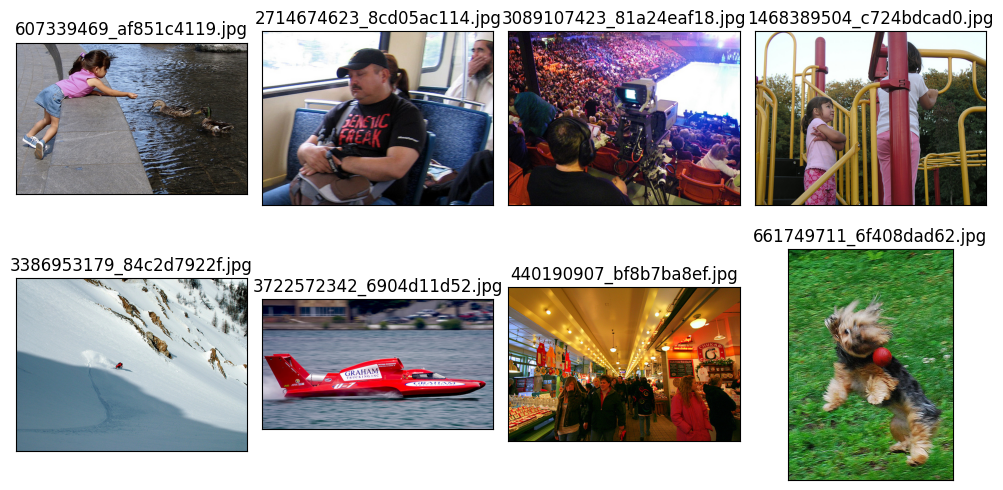

In [ ]:
# Посмотрим фотографии в датасете с данными необходимыми для тестирования
foto_test = list(test_queries['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    #image_path = os.path.join('/content/drive/My Drive/Colab Notebooks/to_upload/test_images', foto_test[i])
    image_path = os.path.join(DATA_PATH, 'test_images', foto_test[i])
    image2 = Image.open(image_path)
    plt.imshow(image2)
    plt.title(foto_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


In [ ]:
# Проверим количество уникальных изображений в обучающем и тестовом датасетах
print('Количество уникальных фото на трейне:', len(train_dataset['image'].unique()))
print('Количество уникальных фото на тесте:', len(test_queries['image'].unique()))

Количество уникальных фото на трейне: 1000
Количество уникальных фото на тесте: 100


In [ ]:
# Также проверим не совпадают ли картинки в обучающем и тестовом датасетах
print('Уникальных картинок в трейне:', len(set(train_dataset['image'])))
print('Уникальных картинок в тесте:', len(set(test_queries['image'])))
print('Уникальных картинок которые есть в обоих наборах:', len(set(train_dataset['image']) & set(test_queries['image'])))

Уникальных картинок в трейне: 1000
Уникальных картинок в тесте: 100
Уникальных картинок которые есть в обоих наборах: 0


Датасеты разделены корректно и изображения в трейне и тестовых наборах не пересекаются.

In [ ]:
# Проверим соответствие текстовых описаний фотографий в обучающем и тестовом датасетах
print('Уникальных текстовых описаний в трейне:', len(set(train_dataset['query_text'])))
print('Уникальных текстовых описаний в тесте:', len(set(test_queries['query_text'])))
print('Уникальных текстовых описаний которые есть в обоих наборах:', len(set(train_dataset['query_text']) & set(test_queries['query_text'])))

Уникальных текстовых описаний в трейне: 977
Уникальных текстовых описаний в тесте: 500
Уникальных текстовых описаний которые есть в обоих наборах: 0


Некоторые изображения в трейне имеют одинаковые текстовые описания. В тестовом наборе есть 500 уникальных описаний для 100 изображений и текстовые описания между трейном и тестом не пересекаются.

### 1.3 Формирование итоговой оценки по фотографиям

In [ ]:
# Резюмируем оценку по трем экспертам. Напишем функцию.
# Функция определяет наиболее частую оценку, полученную от трех экспертов, и возвращает ее. Если все три эксперта дали разные оценки, функция возвращает None.
def result_expert(row):
    res = [0, 0, 0, 0]
    # Берём все оценки экспертов в столбцах
    for i in [2, 3, 4]:
        res[int(row[i]-1)] += 1
    # Если у всех трех экспертов разные оценки возвращаем None
    if max(res) == 1:
        return None
    # Иначе возвращаем наиболее частую оценку
    else:
        return res.index(max(res)) + 1

ExpertAnnotations['result'] = ExpertAnnotations.apply(result_expert, axis=1)
display(ExpertAnnotations.head(5))
print('')
ExpertAnnotations.info()

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  result  
0      1     1.0  
1      2     1.0  
2      2     1.0  
3      2     2.0  
4      2     1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5822 non-null   object 
 1   query_id  5822 non-null   object 
 2   first     5822 non-null   int64  
 3   second    5822 non-null   int64  
 4   third     5822 non-null   int64  
 5   result    5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 273.0+ KB


In [ ]:
# Посмотрим сколько строк с None получили
num_none = ExpertAnnotations['result'].isna().sum()
print(f"Количество None в столбце: {num_none}")

Количество None в столбце: 126


In [ ]:
# Строк очень мало. Удалим их.
ExpertAnnotations.dropna(subset=['result'], inplace=True)

# Преобразуем экспертные оценки к значениям в диапазоне [0, 1]
ExpertAnnotations['result_expert'] = ExpertAnnotations['result'] / 4.0

# Удалим лишние столбцы
columns_to_drop = ['first', 'second', 'third', 'result']
ExpertAnnotations.drop(columns=columns_to_drop, inplace=True)

ExpertAnnotations.head(5)

image                     query_id  result_expert
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2           0.25
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2           0.25
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2           0.25
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2           0.50
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2           0.25

In [ ]:
# Резюмируем данные полученные с помощью краудсорсинга.
# Удалим лишние столбцы
columns_to_drop1 = ['col_poz', 'col_neg']
CrowdAnnotations.drop(columns=columns_to_drop1, inplace=True)

CrowdAnnotations.head(5)

image                     query_id  dol
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0

In [ ]:
# Объединяем обе таблицы в одну
combined_Annotations = ExpertAnnotations.merge(CrowdAnnotations, on=['image', 'query_id'], how='outer')
display(combined_Annotations.head(5))
print('')
combined_Annotations.info()

image                     query_id  result_expert  dol
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2           0.25  0.0
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2           0.25  0.0
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2           0.25  NaN
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2           0.50  NaN
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2           0.25  NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51268 entries, 0 to 51267
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          51268 non-null  object 
 1   query_id       51268 non-null  object 
 2   result_expert  5696 non-null   float64
 3   dol            47830 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


In [ ]:
# Функция объединения оценки эксперта и оценки краудсорсинга. Оценок экспертов очень мало, буду считать их в приоритете.
def combine_scores(row):
    # Если есть оценка эксперта, используем её
    if pd.notna(row['result_expert']):
        return row['result_expert']
    # Если нет оценки эксперта, но есть оценка краудсорсинга, используем её
    elif pd.notna(row['dol']):
        return row['dol']

combined_Annotations['final_score'] = combined_Annotations.apply(combine_scores, axis=1)
columns_to_drop2 = ['result_expert', 'dol']
combined_Annotations.drop(columns=columns_to_drop2, inplace=True)

In [ ]:
display(combined_Annotations.head(5))
print('')
combined_Annotations.info()

image                     query_id  final_score
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         0.25
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         0.25
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         0.25
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         0.50
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         0.25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51268 entries, 0 to 51267
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51268 non-null  object 
 1   query_id     51268 non-null  object 
 2   final_score  51268 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
# Добавим цели в наши датасеты
training_data = train_dataset.merge(combined_Annotations, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='outer')

In [ ]:
display(training_data.head(5))
print('')
training_data.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  final_score  
0  A young child is wearing blue goggles and sitt...         0.25  
1  A young child is wearing blue goggles and sitt...         0.25  
2  A young child is wearing blue goggles and sitt...         0.50  
3  A young child is wearing blue goggles and sitt...         1.00  
4  A young child is wearing blue goggles and sitt...         0.25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51323 non-null  object 
 1   query_id     51323 non-null  object 
 2   query_text   5822 non-null   object 
 3   final_score  51268 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [ ]:
# Cоздадим новый датафрейм с уникальными значениями query_id и соответствующими им query_text
unique_query_texts = training_data.dropna(subset=['query_text'])[['query_id', 'query_text']].drop_duplicates()

In [ ]:
# Проведем объединение изначального датафрейма с этим новым датафреймом, чтобы заполнить пропущенные значения query_text
training_data = training_data.merge(unique_query_texts, on='query_id', how='left', suffixes=('', '_fill'))

In [ ]:
# Заполним пропущенные значения в исходной колонке значениями из новой колонки
training_data['query_text'] = training_data['query_text'].fillna(training_data['query_text_fill'])

In [ ]:
training_data.drop(columns=['query_text_fill'], inplace=True)
display(training_data.head(5))
print('')
training_data.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  final_score  
0  A young child is wearing blue goggles and sitt...         0.25  
1  A young child is wearing blue goggles and sitt...         0.25  
2  A young child is wearing blue goggles and sitt...         0.50  
3  A young child is wearing blue goggles and sitt...         1.00  
4  A young child is wearing blue goggles and sitt...         0.25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51323 non-null  object 
 1   query_id     51323 non-null  object 
 2   query_text   50214 non-null  object 
 3   final_score  51268 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [ ]:
# После добавления текстов, оказалось что есть `query_id` у которых нет описаний. Удалим их.
training_data.dropna(inplace=True)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50159 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50159 non-null  object 
 1   query_id     50159 non-null  object 
 2   query_text   50159 non-null  object 
 3   final_score  50159 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


### 1.4 ВЫВОДЫ ПО РАЗДЕЛУ 1

*Анализ всех датасетов показал*, что во всех датасетах нет пропущенных значений и дубликатов. Дополнительной обработки данные не требуют. Качество данных очень хорошее. Визуализация данных выполнена.

*Датасеты разделены корректно*. Изображения или текстовые описания не пересекается между датасетами в трейне и тесте . Однако, есть изображения которые имеют несколько текстовых описаний. Необходимо учитывать различные способы интерпретации одного и того же изображения.

Обработал датасеты с оценками экспертов и оценками получеными в результате краудсорсинга. *Получил датасет с итоговой оценкой описания соответствия изображения.*

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

### 2.1 Очистка датасета.

Вся необходимая информация, с текстом описания картинки, находится в train_dataset['query_id']. Необходимо создать алгоритм который просмотрит все картинки и удалит запрещенные.

In [ ]:
# Создадим список слов связанных с детьми и подростками
forbidden_words = ['child', 'children', 'baby', 'babies', 'boy', 'boys', 'girl', 'girls', 'teenager', 'schoolboy', 'kid', 'kids',
                   'infant', 'infants', 'toddler', 'toddlers', 'newborn']

In [ ]:
# Функция подготовки текста для анализа и отчистки
def process_text(text):
    # Очищаем текст от неалфавитных символов и приводим к нижнему регистру
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Токенизируем текст
    tokens = nltk.word_tokenize(text)
    # Лемматизация
    lemmas = [lemmatize.lemmatize(word) for word in tokens]
    return lemmas

# Функция для проверки наличия запрещенных слов в описании
def have_forbidden_words(text, forbidden_list):
    lemmatized_text = process_text(text)
    return any(word in lemmatized_text for word in forbidden_list)

In [ ]:
# 1. Очистка от запрещенных слов
training_data['forbidden'] = training_data['query_text'].apply(lambda x: have_forbidden_words(x, forbidden_words))
filtered_train_dataset_com = training_data[~training_data['forbidden']]

# 2. Очистка "плохих" изображений
# Получаем список "плохих" изображений
bad_images = training_data[training_data['forbidden']]['query_id'].apply(lambda x: x[:-2]).unique()
# Оставляем только те изображений, которые не относятся к "плохим" изображениям
filtered_train_dataset = filtered_train_dataset_com[~filtered_train_dataset_com['image'].isin(bad_images)]

# Перед очисткой запомним изначальный размер датасета (кол-во изображений)
initial_size = training_data.shape[0]
# Размер датасета после очистки
final_size = filtered_train_dataset.shape[0]
print(f"Удалено {initial_size - final_size} изображений")

Удалено 21130 изображений


In [ ]:
# Удаляем временный столбец 'forbidden'
filtered_train_dataset.drop(columns=['forbidden'], inplace=True)
display(filtered_train_dataset.head(5))
print('')
filtered_train_dataset.info()

<ipython-input-79-b46e9cf67dd4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_dataset.drop(columns=['forbidden'], inplace=True)


image                     query_id  \
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                         query_text  final_score  
22  A man sleeps under a blanket on a city street .         0.25  
23  A man sleeps under a blanket on a city street .         0.50  
24  A man sleeps under a blanket on a city street .         0.50  
25  A man sleeps under a blanket on a city street .         0.50  
26  A man sleeps under a blanket on a city street .         0.25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29029 entries, 22 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        29029 non-null  object 
 1   query_id     29029 non-null  object 
 2   query_text   29029 non-null  object 
 3   final_score  29029 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [ ]:
filtered_train_dataset.shape

(29029, 4)

**ВЫВОДЫ: Удалено 21130 изображений**

### 2.2 Векторизация текстов (train)

Сделайте векторизацию текстового описания одним из следующих методов:
o	TF-IDF;
o	BERT;
o	word2vec.



In [ ]:
# Установка стоп-слов
stopwords_set = set(stopwords.words('english'))

In [ ]:
# Применение TF-IDF векторизатора к текстовым данным
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_set))
tfidf_train = tfidf_vectorizer.fit_transform(filtered_train_dataset['query_text'])
print("Размер матрицы для обучающего набора (текст):", tfidf_train.shape)

Размер матрицы для обучающего набора (текст): (29029, 1137)


### 2.3 Векторизация изображений (train)

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Сделайте векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch.

In [ ]:
PATH = '/content/to_upload'

In [ ]:
# Загрузка и предварительная обработка данных
def load_train(path=PATH, img_size=(224, 224), batch_size=64) -> ImageDataGenerator:
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # cоздание объекта для аугментации изображений
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=filtered_train_dataset,          # указываем, откуда брать данные
        directory=Path(path, 'train_images'),      # папка, в которой хранится датасет
        x_col='image',                             # имена файлов изображений
        y_col='final_score',                       # метки к изображениям
        target_size=img_size,                      # к какому размеру приводить изображения
        batch_size=batch_size,                     # размер батча
        class_mode='raw',                          # в каком виде выдавать метки классов
        seed=12345)                                # фиксируем генератор случайных чисел
    return train_gen_flow

# Определение архитектуры модели
def create_model(input_shape=(224, 224, 3)):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Векторизация изображений
def vectorize_pictures(model, train_data):
    predictions = model.predict(train_data)
    return predictions

In [ ]:
# Запускаем векторизацию
%%time
pict_embeds = vectorize_pictures(create_model(), load_train())

Found 29029 validated image filenames.
454/454 [==============================] - 5931s 13s/step
CPU times: user 2h 21min, sys: 26min 40s, total: 2h 47min 41s
Wall time: 1h 39min 27s


In [ ]:
pict_embeds.shape

(29029, 2048)

In [ ]:
print(pict_embeds)

[[0.73929757 1.5797782  0.34616446 ... 0.339173   0.503447   0.48897195]
 [0.5387166  2.8914702  0.2814359  ... 0.48289818 0.51024187 1.5835676 ]
 [1.6237482  1.4135227  0.14225352 ... 0.8006116  0.37563726 0.21215104]
 ...
 [0.52297497 0.20004602 0.17001131 ... 0.34355545 0.49984133 0.48778418]
 [0.24666299 0.9523414  0.0791377  ... 0.01323641 0.9957705  0.37461963]
 [0.1572151  1.0528262  0.01652879 ... 1.2328639  0.4660866  0.3275206 ]]


### 2.4 Объединение векторов (train)

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
print("Размер датасета изображений:", pict_embeds.shape)
print("Размер датасета текстов:", tfidf_train.shape)

Размер датасета изображений: (29029, 2048)
Размер датасета текстов: (29029, 1137)


In [ ]:
# Объединение векторов изображений и текста
combined_features_train = np.hstack([np.vstack(pict_embeds), tfidf_train.toarray()])
print("Размер объединенного датасета:", combined_features_train.shape)

Размер объединенного датасета: (29029, 3185)


**ВЫВОДЫ:**

*combined_features_train* - это итоговое объединенное векторное представление изображений и текста для обучающего датасета.

*Размер датасета: (29029, 3185)* - означает, что в нём есть 29029 обучающих примеров, и каждый пример представлен вектором из 3185 компонентов.

Более подробно по размерности:

29029 - это количество пар изображение/текст в датасете.
3185 - это общее количество признаков *(или размерность вектора)* для каждой пары изображение/текст. Она получилась путем объединенния размерности векторов из pict_embeds и dense_tfidf_train.

***В результате данные представлены в виде матрицы, где каждая строка - это пара изображение-текст, а каждый столбец - это признак этой пары.***

Если конечно я всё правильно сделал =)

## 3. Обучение модели предсказания соответствия

1.	Создайте модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов.
2.	Выберите метрику, по которой вы будете сравнивать точность различных моделей.
3.	Обучите несколько моделей и подберите их гиперпараметры. В качестве моделей обязательно нужно рассмотреть:

   •	Линейную регрессию;
   
   •	Полносвязные нейронные сети.

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### 3.1 Подготовим обучающую и тестовые выборки

In [ ]:
# Выделяем признаки и целевую переменную
X = combined_features_train
y = filtered_train_dataset['final_score']
groups = filtered_train_dataset['image']

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=groups))
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

In [ ]:
# Отмасштабируем наши данные
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 3.2 LinearRegression

In [ ]:
%%time
model_lr = LinearRegression(positive=True)
model_lr.fit(X_train, y_train)
RMSE_lr = mean_squared_error(y_test, model_lr.predict(X_test), squared=False)

CPU times: user 3min 28s, sys: 2.73 s, total: 3min 31s
Wall time: 3min 31s


In [ ]:
# Обучение Константной модели
y_pred_zero = [0] * len(y_test)
RMSE_zero = mean_squared_error(y_test, y_pred_zero, squared=False)

Есть линейная регрессия. Но мы знаем, что эта модель склонна к переобучению. Поэтому необходимо дополнительно обучить линейную модель с регуляризацией (Lass/Ridge - на твое усмотрение)

In [ ]:
# Обучение модели Ridge регрессии
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)
RMSE_ridge = mean_squared_error(y_test, model_ridge.predict(X_test), squared=False)

# Обучение модели Lasso регрессии
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)
RMSE_lasso = mean_squared_error(y_test, model_lasso.predict(X_test), squared=False)

In [ ]:
print(f'RMSE LinearRegression: {RMSE_lr:.4f}')
print(f'RMSE Zero Baseline: {RMSE_zero:.4f}')
print(f'RMSE Ridge: {RMSE_ridge:.4f}')
print(f'RMSE Lasso: {RMSE_lasso:.4f}')

RMSE LinearRegression: 0.2450
RMSE Zero Baseline: 0.2794
RMSE Ridge: 0.2478
RMSE Lasso: 0.2513


- Zero Baseline показала прогноз, предсказывая ноль для всех наблюдений.

- Ridge регрессия вводит L2 регуляризацию в модель, что помогает предотвратить переобучение. Значительного улучшения по сравнению с обычной линейной регрессией не произошло.

- Lasso регрессия вводит L1 регуляризацию в модель, что тоже помогает предотвратить переобучение, плюс она проводит отбор признаков, зануляя коэффициенты при менее важных переменных.  Lasso регрессия показала результат незначительно хуже простой линейной и Ridge регрессии.

**Общий вывод:**
*Простая линейная регрессия показала наилучший результат*

### 3.3 Полносвязная нейронная сеть

In [ ]:
# Cоздадим полносвязную нейронную сеть
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))
X_train.shape

torch.Size([20433, 3185])

In [ ]:
# Создаем DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(Net, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.Linear(hidden_dims[2], hidden_dims[3]),
            nn.ReLU(),
            nn.Linear(hidden_dims[3], output_dim),
            nn.Sigmoid()
        )
        # Инициализация весов
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        return self.layers(x)

In [ ]:
# Определяем параметры сети
hidden_dims = [1200, 600, 200, 10]
net = Net(X_train.shape[1], hidden_dims, 1)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.8)
loss_func = nn.MSELoss()

In [ ]:
%%time
num_epochs = 100
best_rmse = float('inf')
for epoch in range(num_epochs):
    net.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = net(X_batch).flatten()
        loss_value = loss_func(preds, y_batch)
        loss_value.backward()
        optimizer.step()
    with torch.no_grad():
        net.eval()
        test_preds = net(X_test).flatten()
        rmse = torch.sqrt(loss_func(test_preds, y_test))
        best_rmse = min(best_rmse, rmse.item())
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f'Эпоха {epoch}, RMSE: {rmse:.4f}')

print(f'Лучшая метрика RMSE: {best_rmse:.4f}')

Эпоха 0, RMSE: 0.2585
Эпоха 10, RMSE: 0.2546
Эпоха 20, RMSE: 0.2536
Эпоха 30, RMSE: 0.2547
Эпоха 40, RMSE: 0.2574
Эпоха 50, RMSE: 0.2621
Эпоха 60, RMSE: 0.2659
Эпоха 70, RMSE: 0.2714
Эпоха 80, RMSE: 0.2751
Эпоха 90, RMSE: 0.2768
Эпоха 99, RMSE: 0.2816
Лучшая метрика RMSE: 0.2536
CPU times: user 23min 32s, sys: 7.59 s, total: 23min 39s
Wall time: 23min 46s


### 3.4 ВЫВОДЫ по разделу

Я получил метрики RMSE для двух моделей: полносвязной нейронной сети и линейной регрессии.

Полносвязная нейронная сеть: RMSE = 0.2536
Линейная регрессия: RMSE = 0.2450

**Метрика RMSE (Root Mean Square Error)** - это корень из среднего квадратичного отклонения прогнозируемых значений от истинных. Или подругому это метрика показывает, насколько в среднем модель ошибается при прогнозировании.

Чем меньшее значение RMSE тем лучше модель. Следовательно полносвязная нейронная сеть победила 0.2450 < 0.2536.

## 4. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### 4.1 Векторизация текстов (test)

In [ ]:
tfidf_test = tfidf_vectorizer.transform(test_queries['query_text'])
print("Размер матрицы для тестового набора:", tfidf_test.shape)

Размер матрицы для тестового набора: (500, 1137)


### 4.2 Векторизация изображений (test)

In [ ]:
# Загрузка и предварительная обработка данных
def load_train_test(path=PATH, img_size=(224, 224), batch_size=64) -> ImageDataGenerator:
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # cоздание объекта для аугментации изображений
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=test_queries,                    # указываем, откуда брать данные
        directory=Path(path, 'test_images'),       # папка, в которой хранится датасет
        x_col='image',                             # имена файлов изображений
       # y_col=None,                                # метки к изображениям
        target_size=img_size,                      # к какому размеру приводить изображения
        batch_size=batch_size,                     # размер батча
        class_mode=None,                           # в каком виде выдавать метки классов
        seed=12345)                                # фиксируем генератор случайных чисел
    return train_gen_flow

# Определение архитектуры модели
def create_model_test(input_shape=(224, 224, 3)):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Векторизация изображений
def vectorize_pictures_test(model, train_data):
    predictions = model.predict(train_data)
    return predictions

In [ ]:
# Запускаем векторизацию
%%time
pict_embeds_test = vectorize_pictures_test(create_model_test(), load_train_test())

Found 500 validated image filenames.
8/8 [==============================] - 103s 12s/step
CPU times: user 2min 28s, sys: 24.7 s, total: 2min 53s
Wall time: 1min 46s


In [ ]:
pict_embeds_test.shape

(500, 2048)

### 4.3 Объединение векторов (test)

In [ ]:
print("Размер датасета изображений:", pict_embeds_test.shape)
print("Размер датасета текстов:", tfidf_test.shape)

Размер датасета изображений: (500, 2048)
Размер датасета текстов: (500, 1137)


In [ ]:
# Объединение векторов изображений и текста
combined_features_test = np.hstack([np.vstack(pict_embeds_test), tfidf_test.toarray()])
print("Размер объединенного датасета:", combined_features_test.shape)

Размер объединенного датасета: (500, 3185)


In [ ]:
X_test_torch = torch.FloatTensor(combined_features_test)

In [ ]:
# Переключили модель в режим оценки
net.eval()
with torch.no_grad():
    test_preds = net(X_test_torch).flatten().numpy()

### 4.4 Выберем 10 случайных запросов из файла с тестовыми запросами и посмотрим на результаты

КАЧЕСТВЕННО ПРОТЕСТИТРОВАТЬ У МЕНЯ НЕ ПОЛУЧАЕТСЯ.......

In [ ]:
def get_picture(text, tfidf_vectorizer, net, tfidf_test, pict_embeds_test, df_images, PATH) -> None:

    # Получаем TFIDF представление текста
    text_tfidf = tfidf_vectorizer.transform([text]).toarray()
    # Объединяем эмбеддинг изображения и tfidf текста
    X = np.concatenate((pict_embeds_test, np.tile(text_tfidf, (pict_embeds_test.shape[0], 1))), axis=1)
    # Прогоняем через вашу сеть для предсказания релевантности
    X_test_torch = torch.FloatTensor(X)
    net.eval()
    with torch.no_grad():
        predictions = net(X_test_torch).flatten().numpy()

    # Сортируем изображения на основе релевантности
    df = pd.concat((df_images, pd.Series(predictions, name='pred')), axis=1)
    top = list(df.sort_values(by='pred', ascending=False)['image'].head(5))
    top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5))
    print('-' * 20, text, '-' * 20)

    # Отображаем наиболее релевантные изображения
    fig = plt.figure(figsize=(15,5))
    for i in range(5):
        fig.add_subplot(1, 5, i+1, title=round(top_score[i], 2))
        image_path = os.path.join(PATH, 'test_images', top[i])
        image = Image.open(image_path)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [ ]:
# Для выбора 10 случайных запросов:
samples = test_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['A woman and a girl ride a sled down a hill standing up .',
 'A young boy jumps his bicycle on a tagged bike ramp .',
 'A tennis player wearing a blue shirt raises his hands and smiles .',
 'A girl is wearing a blue wig under a brown hooded jacket .',
 'Two West Highland Terriers chase a red ball .',
 'Two girls walking next to each other and talking .',
 'Two men are standing under what looks to be a giant robot .',
 "Four people are cavorting on the rocks at a river 's edge",
 'A brown and white dog walks in the snow with a big chunk of snow in his mouth .',
 'Three people are doing ballet exercises in extravagant costumes .']

-------------------- A woman and a girl ride a sled down a hill standing up . --------------------


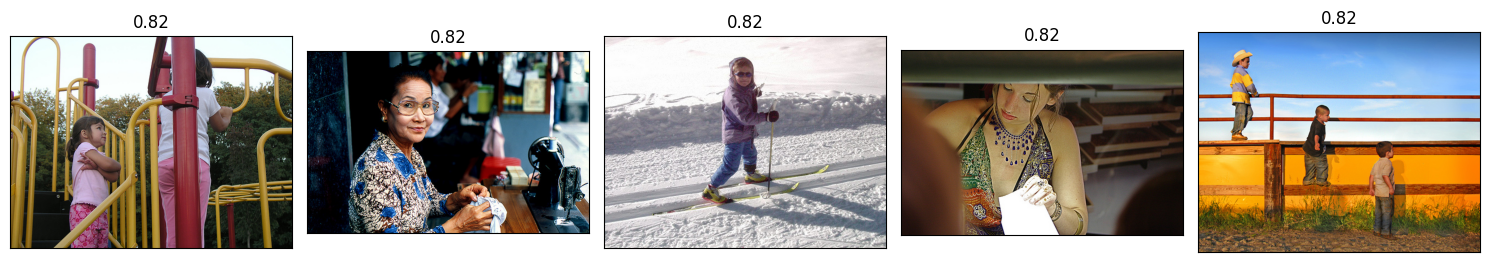

-------------------- A young boy jumps his bicycle on a tagged bike ramp . --------------------


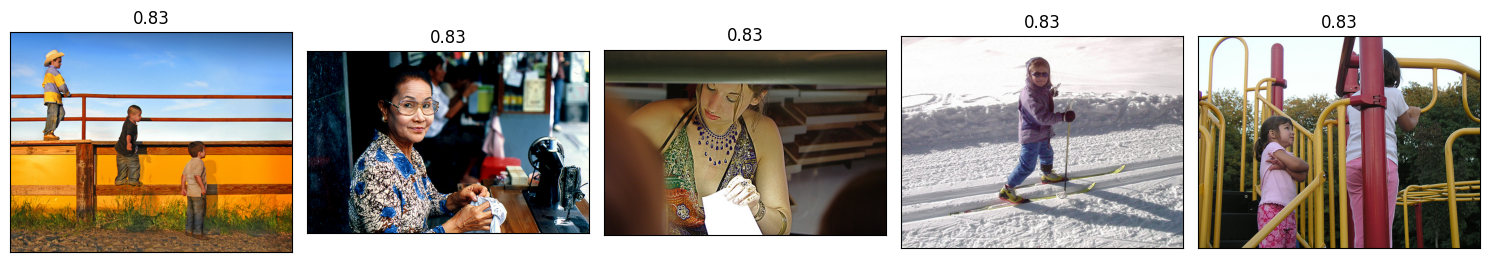

-------------------- A tennis player wearing a blue shirt raises his hands and smiles . --------------------


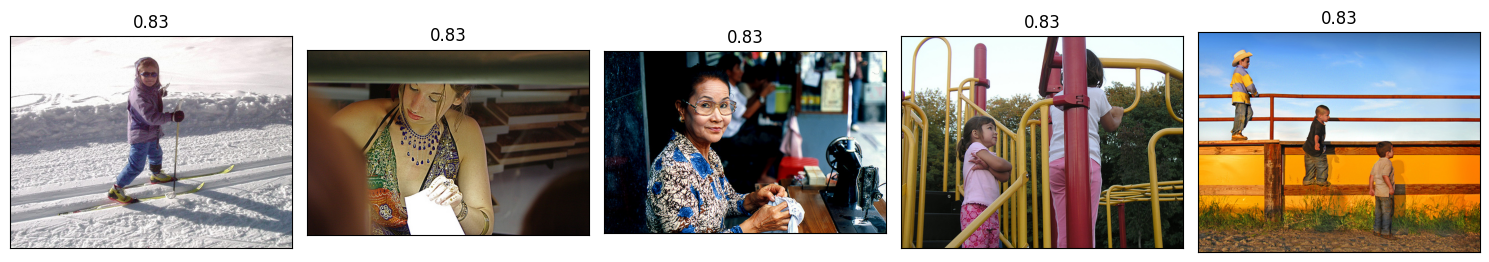

-------------------- A girl is wearing a blue wig under a brown hooded jacket . --------------------


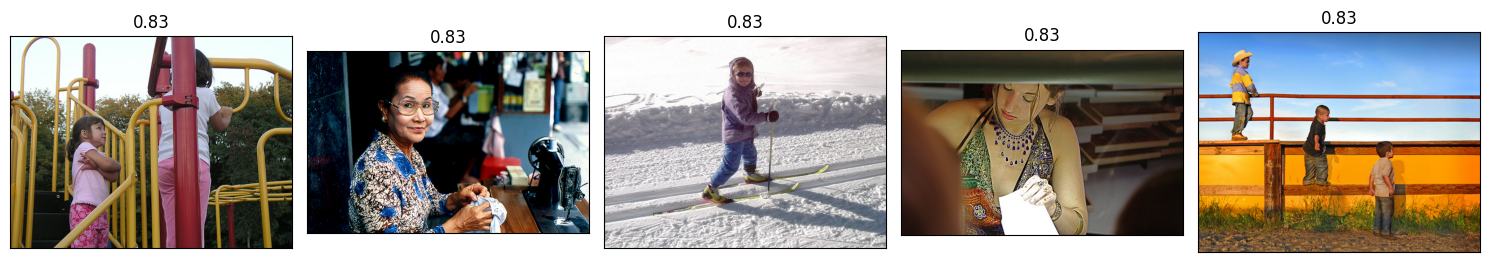

-------------------- Two West Highland Terriers chase a red ball . --------------------


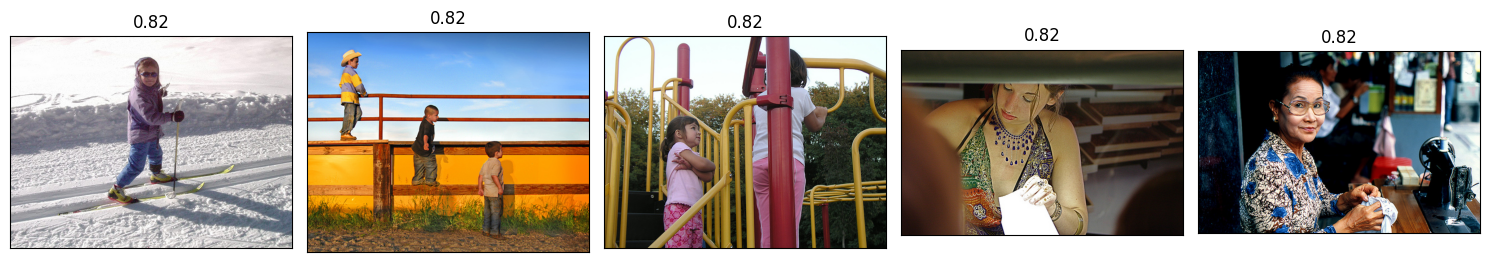

-------------------- Two girls walking next to each other and talking . --------------------


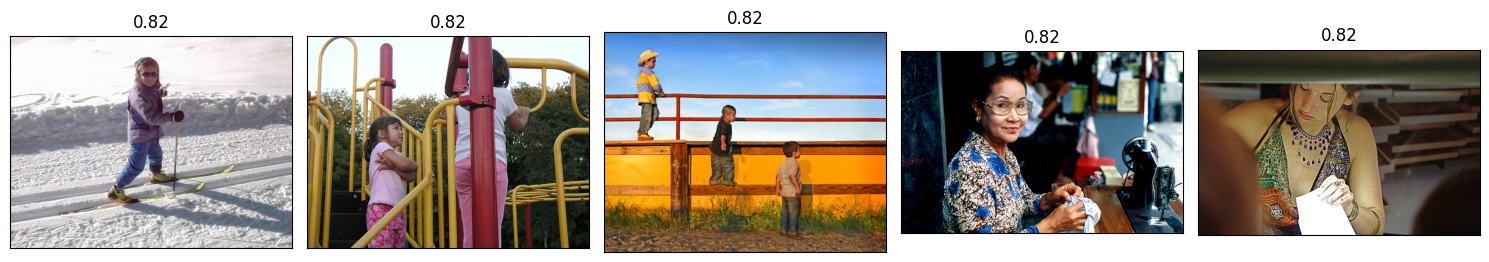

-------------------- Two men are standing under what looks to be a giant robot . --------------------


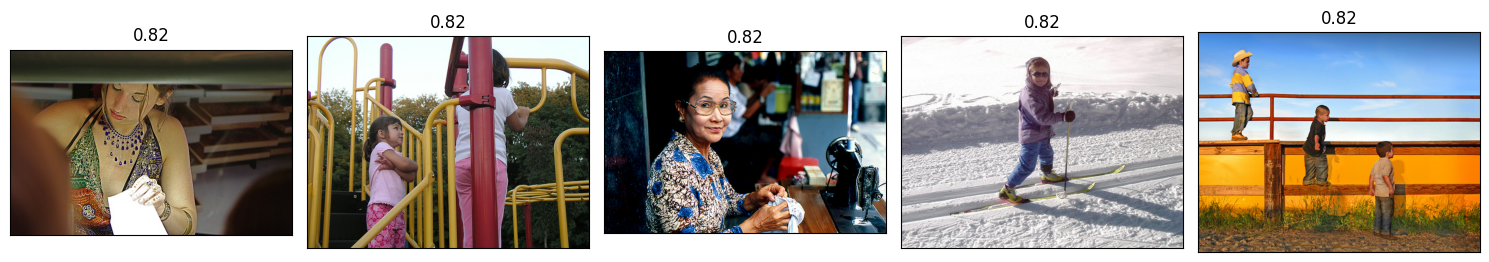

-------------------- Four people are cavorting on the rocks at a river 's edge --------------------


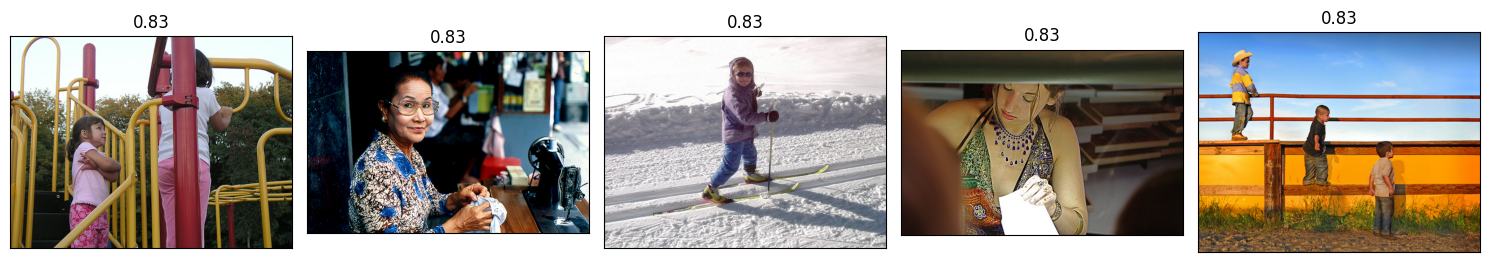

-------------------- A brown and white dog walks in the snow with a big chunk of snow in his mouth . --------------------


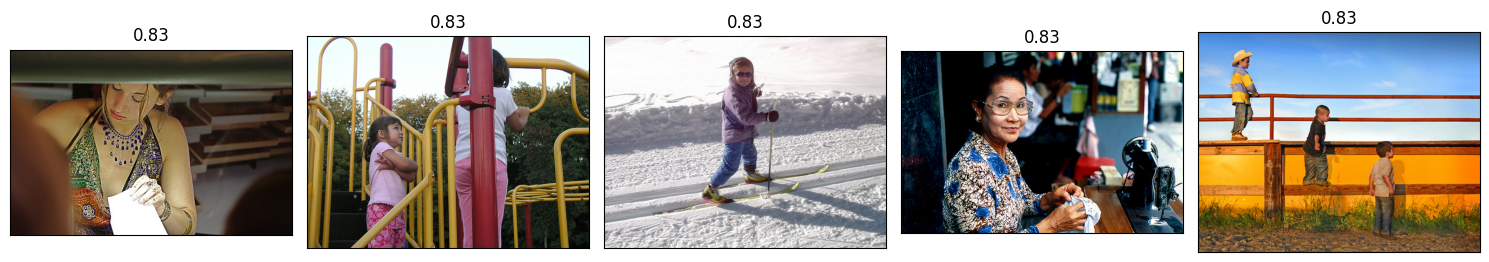

-------------------- Three people are doing ballet exercises in extravagant costumes . --------------------


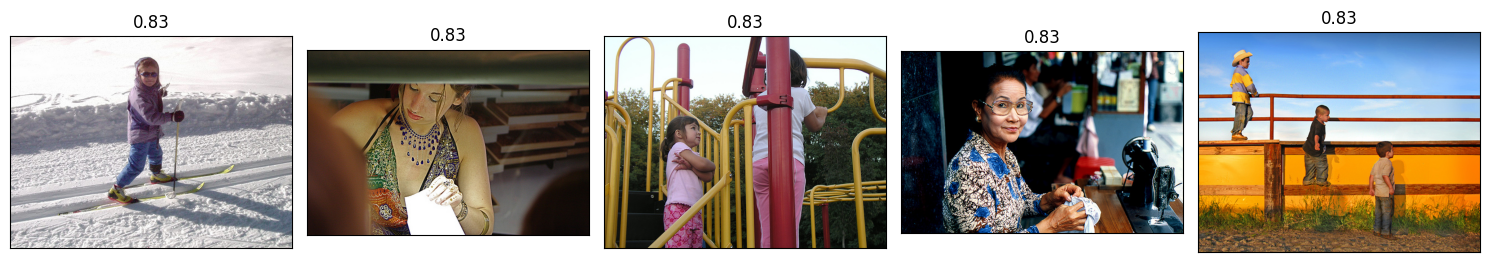

In [ ]:
for text in text_test:
    get_picture(text, tfidf_vectorizer, net, tfidf_test, pict_embeds_test, test_queries, PATH)

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Здесь я вижу достаточно "типичную" картинку. К сожалению описания и изображения не соответствуют друг другу. Совсем.
    
Как я тебе писал выше, путей много, и они вроде бы правильные, но к результату приводят далеко не все.
    
В этом проекте очень много составляющих: сами данные и их подготовка, способы векторизации изображений и текстов, наше умение создавать архитектуры и обучать нейронки.
    
К сожалению сейчас не вышло. Повторюсь - так бывает. Ниже я опишу несколько вариантов стратегий, которые работают.    

</div>

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Идеи и альтернативные подходы</b>
  Если хочешь получить хорошо работающее решение без обучения, то можешь провести эксперимент с нейронной сетью CLIP от OPEN AI (это не обязательно, только если хочешь добиться хороших результатов в этом проекте).

  Про эту нейронку много где написано, но можешь посмотреть например вот здесь  https://habr.com/ru/post/539312/.

  А для написания  реализации наиболее удобной лично для меня оказалась библиотека sbert. https://www.sbert.net/examples/applications/image-search/README.html  
    
    
<hr>    
    
Также неплохо работает следующий подход без предобученных моделей (к тому же легко реализуемый).
    
    
Вместо того, чтобы подавать на вход модели изображение + текст и получать меру соответствия, поступаем по другому.
    
На вход модели подаем вектор описания, а на выходе учимся предсказывать вектор изображения.
    
По поводу метрик тут ситуация следующая. Точно работает следующий подход
    
  - берем метрику mse, но тогда нужно чтобы модель её уменьшала. А значит в обучении используем только пары заведомо сответствующие друг другу

Можно попробовать использовать косинусное расстояние, она позволяет использовать все данные (если есть соответствие то выдает 1, если нет то 0).
    
Также можно попробовать усложнить модель, например и изображения и тексты отправлять в пространство размерностью 256 и уже в этом пространстве учиться их "сближать".
    
По поводу методов векторизации: я бы использовать resnet18 для изображений (размерность эмбеддинга избражения 512) и БЕРТ для текстов (768).
    
***
    
А еще я видел удачный проект, где для векторизации изображений использовалось предсказание Resnet в котором не отключался последний слой. Получился вектор предсказаний верояятности что изображение принадлежит к каждому из 1000 классов Imagenet. И в сочетании с подходом "мешок слов" для текстов это может дать неплохой результа. Такая модель находит людей, собак, машины, снег и т.д.
    
***
    
Есть еще один вариант. Здесь мы работаем с экспертными оценками и сравнительно малым датасетом. Для текстов используется BERT и модель учится до лосса около  0,18. Да, нужно постараться с подбором гиппрпараметров, шагом обучения. Но результат выглядит неплохо - модель начинает узнавать собак, людей, снег, море и т.д.
</div>

## 5. ИТОГОВЫЕ ВЫВОДЫ ПО ПРОЕКТУ

В данном проекте было необходимо разработать демонстрационную версию поиска изображений по запросу.

Входные данные были проанализированны и обработаны. Сформированна итоговая (обобщенная) оценка по фотографиям.

Проведена векторизация тестов и изображений с последующим их объединением в один массив векторов.

Затем обучены две модели:

  •	Линейная регрессия;
  
  •	Полносвязная нейронная сеть.

Лучший показатель RMSE показала полносвязная нейронная сеть 0.2450 < 0.2536. На тесте используем её.

В конце работы для качественного тестирования возможностей разработана функция которая по тексту должна вернуть 5 наиболее похожих картинок. Использовался набор тестовых картинок.

Результат не самый хороший. По всей видимости надо рассматривать те варианты которые вы указали.
